# 02. PyTorch Classification Exercises

The following is a template for 02. PyTorch Classification exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

## Resources
* These exercises are based on [notebook 02 of the learn PyTorch course](https://www.learnpytorch.io/02_pytorch_classification/).
* You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [1]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cuda"

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

In [3]:
# Turn data into a DataFrame
import pandas as pd

N_SAMPLES = 1000

X, y = make_moons(
    n_samples=N_SAMPLES,
    shuffle=True,
    noise=0.03
)

moons = pd.DataFrame(
    {
        "X1": X[:, 0],
        "X2": X[:, 1],
        "label": y
    }
)

moons

,X1,X2,label
0,1.792598,-0.219861,1
1,1.888622,0.187059,1
2,0.273694,0.982886,0
3,0.344521,-0.242739,1
4,0.334343,-0.309565,1
...,...,...,...
995,1.877134,-0.014786,1
996,-0.012013,1.016932,0
997,0.019107,0.520658,1
998,0.920886,0.373793,0


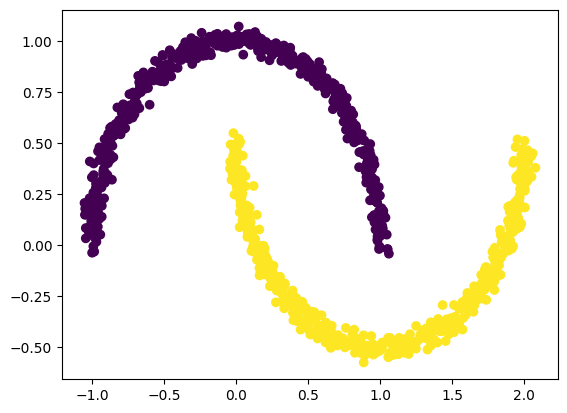

In [4]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0], # everything from column 0
            y=X[:,1], # everything from column 1
            c = y # different lables different colors
            )

In [5]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    train_size = 0.8
                                                    )


## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [6]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self):
      super().__init__()
      self.layer_one = nn.Sequential(
          nn.Linear(in_features = 2, out_features = 10),
          nn.ReLU(),
          nn.Linear(in_features = 10, out_features = 10),
          nn.ReLU(),
          nn.Linear(in_features = 10, out_features = 1),
          nn.ReLU()
      )

    def forward(self, x):
        return self.layer_one(x)

# Instantiate the model
model_0 = MoonModelV0().to(device)
model_0


MoonModelV0(
  (layer_one): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): ReLU()
  )
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [7]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [8]:
# What's coming out of our model?
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# logits (raw outputs of model)
print("Logits:")
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test).to(device)
print(y_logits[:5])

# Prediction probabilities
print("Pred probs:")
model_0.eval()
with torch.inference_mode():
  y_preds = torch.sigmoid(y_logits)
print(y_preds[:5])

# Prediction labels
print("Pred labels:")
model_0.eval()
with torch.inference_mode():
  y_labels = torch.argmax(y_preds, dim=1)
print(y_labels[:5])

Logits:
tensor([[0.0982],
        [0.1149],
        [0.0000],
        [0.0625],
        [0.0985]], device='cuda:0')
Pred probs:
tensor([[0.5245],
        [0.5287],
        [0.5000],
        [0.5156],
        [0.5246]], device='cuda:0')
Pred labels:
tensor([0, 0, 0, 0, 0], device='cuda:0')


In [9]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="binary", num_classes=2).to(device) # send accuracy function to device
acc_fn

BinaryAccuracy()

In [10]:
from tqdm.auto import tqdm
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in tqdm(range(epochs)):
  ### Training
  model_0.train()
  # 1. Forward pass (logits output)

  y_logits = model_0(X_train).squeeze()

  # Turn logits into prediction probabilities
  y_preds = torch.sigmoid(y_logits)

  # Turn prediction probabilities into prediction labels
  y_labels = torch.round(y_preds)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs, raw logits cuz we use BCEWithLogits

  # Calculate the accuracy
  acc = acc_fn(y_preds, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()

  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    y_logits_test = model_0(X_test).squeeze()
    # Turn the test logits into prediction labels
    #y_label_test = torch.round(torch.sigmoid(y_logits_test))

    # Turn logits into prediction probabilities
    y_preds_test = torch.sigmoid(y_logits_test)

    # Turn prediction probabilities into prediction labels
    y_label_test = torch.round(y_preds_test)

    # 2. Caculate the test loss/acc
    loss_test = loss_fn(y_logits_test, y_test)
    acc_test = acc_fn(y_label_test, y_test.int())

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epochs: {epoch:.4f} | Train loss: {loss:.4f} Train acc: {acc:.4f} | Test loss: {loss_test:.4f} Test acc: {acc_test:.4f}")


  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs: 0.0000 | Train loss: 0.6884 Train acc: 0.7375 | Test loss: 0.6854 Test acc: 0.7450
Epochs: 100.0000 | Train loss: 0.5526 Train acc: 0.8112 | Test loss: 0.5566 Test acc: 0.7700
Epochs: 200.0000 | Train loss: 0.4923 Train acc: 0.8675 | Test loss: 0.4924 Test acc: 0.8250
Epochs: 300.0000 | Train loss: 0.4678 Train acc: 0.8788 | Test loss: 0.4649 Test acc: 0.8650
Epochs: 400.0000 | Train loss: 0.4542 Train acc: 0.8875 | Test loss: 0.4504 Test acc: 0.8750
Epochs: 500.0000 | Train loss: 0.4442 Train acc: 0.8963 | Test loss: 0.4392 Test acc: 0.8750
Epochs: 600.0000 | Train loss: 0.4352 Train acc: 0.9062 | Test loss: 0.4292 Test acc: 0.8800
Epochs: 700.0000 | Train loss: 0.4255 Train acc: 0.9125 | Test loss: 0.4164 Test acc: 0.8950
Epochs: 800.0000 | Train loss: 0.4143 Train acc: 0.9225 | Test loss: 0.4002 Test acc: 0.9200
Epochs: 900.0000 | Train loss: 0.3998 Train acc: 0.9413 | Test loss: 0.3839 Test acc: 0.9350


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [11]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

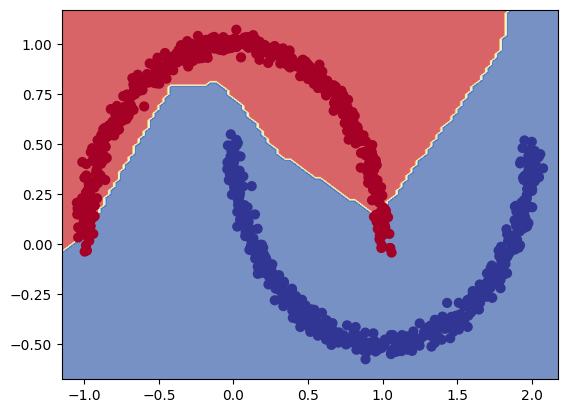

In [12]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_0, X, y)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

In [13]:
# Create a straight line tensor
START = 0
END = 1
STEP = 0.01

line = torch.arange(START, END, STEP)
line

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900])

In [14]:
# Test torch.tanh() on the tensor and plot it
tan_h = torch.tanh(line)
tan_h

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0599, 0.0699, 0.0798,
        0.0898, 0.0997, 0.1096, 0.1194, 0.1293, 0.1391, 0.1489, 0.1586, 0.1684,
        0.1781, 0.1877, 0.1974, 0.2070, 0.2165, 0.2260, 0.2355, 0.2449, 0.2543,
        0.2636, 0.2729, 0.2821, 0.2913, 0.3004, 0.3095, 0.3185, 0.3275, 0.3364,
        0.3452, 0.3540, 0.3627, 0.3714, 0.3799, 0.3885, 0.3969, 0.4053, 0.4136,
        0.4219, 0.4301, 0.4382, 0.4462, 0.4542, 0.4621, 0.4699, 0.4777, 0.4854,
        0.4930, 0.5005, 0.5080, 0.5154, 0.5227, 0.5299, 0.5370, 0.5441, 0.5511,
        0.5581, 0.5649, 0.5717, 0.5784, 0.5850, 0.5915, 0.5980, 0.6044, 0.6107,
        0.6169, 0.6231, 0.6291, 0.6351, 0.6411, 0.6469, 0.6527, 0.6584, 0.6640,
        0.6696, 0.6751, 0.6805, 0.6858, 0.6911, 0.6963, 0.7014, 0.7064, 0.7114,
        0.7163, 0.7211, 0.7259, 0.7306, 0.7352, 0.7398, 0.7443, 0.7487, 0.7531,
        0.7574])

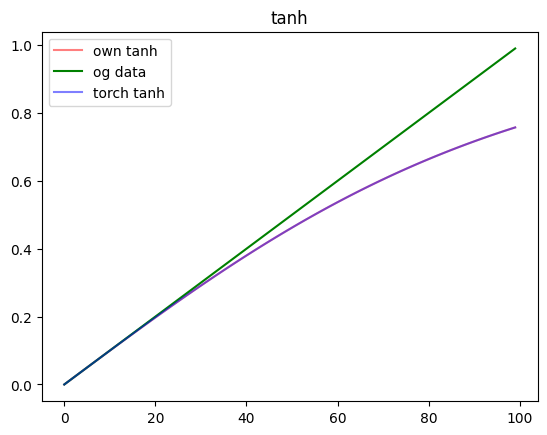

In [15]:
# Replicate torch.tanh() and plot it
def tanh(z):
	return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

plt.plot(tanh(line),color="r", label = "own tanh",alpha = 0.5)
plt.plot(line, color="g", label = "og data")
plt.plot(tan_h, color="b", label = "torch tanh",alpha = 0.5)
plt.title("tanh")
plt.legend()

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

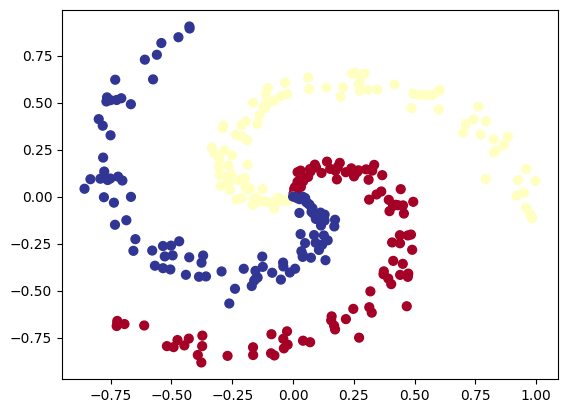

In [16]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [17]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float32) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    train_size = 0.8)

In [18]:
y_train.shape

torch.Size([240])

In [19]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [21]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class MultiClassModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.Tanh(),
        nn.Linear(in_features=10, out_features=10),
        nn.Tanh(),
        nn.Linear(in_features=10, out_features=4),
        nn.Tanh()
    )

  def forward(self,x: torch.Tensor):
      return self.layer1(x)

# Instantiate model and send it to device
model_1 = MultiClassModel().to(device)
model_1

MultiClassModel(
  (layer1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=4, bias=True)
    (5): Tanh()
  )
)

In [22]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_test)
print(y_logits[:10])

print("Pred probs:")
model_1.eval()
with torch.inference_mode():
  y_preds = torch.softmax(y_logits, dim=1)
print(y_preds[:10])

print("Pred labels:")
model_1.eval()
with torch.inference_mode():
  y_labels = torch.argmax(y_preds, dim=1)
print(y_labels[:10])

Logits:
tensor([[-0.0035,  0.0405, -0.0501, -0.1046],
        [ 0.0152, -0.0241, -0.0664, -0.0894],
        [-0.0199, -0.1103, -0.0794, -0.0715],
        [-0.0062,  0.0341, -0.0513, -0.1037],
        [ 0.0642,  0.0968, -0.0431, -0.1022],
        [-0.0105,  0.0093, -0.0566, -0.0993],
        [ 0.0356, -0.0574, -0.0734, -0.0812],
        [ 0.0409, -0.0430, -0.0714, -0.0845],
        [-0.0163,  0.0613, -0.0429, -0.1110],
        [ 0.0171,  0.1360, -0.0273, -0.1175]], device='cuda:0')
Pred probs:
tensor([[0.2562, 0.2677, 0.2445, 0.2316],
        [0.2643, 0.2541, 0.2436, 0.2380],
        [0.2628, 0.2401, 0.2476, 0.2496],
        [0.2561, 0.2667, 0.2448, 0.2323],
        [0.2647, 0.2734, 0.2378, 0.2241],
        [0.2571, 0.2622, 0.2455, 0.2352],
        [0.2704, 0.2464, 0.2425, 0.2406],
        [0.2706, 0.2488, 0.2419, 0.2387],
        [0.2523, 0.2726, 0.2456, 0.2295],
        [0.2527, 0.2846, 0.2417, 0.2209]], device='cuda:0')
Pred labels:
tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 1], device='cuda

In [23]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model_1.parameters(),
                            lr = 0.01)

In [24]:
# Build a training loop for the model

# Loop over data
epochs = 1000

for epoch in tqdm(range(epochs)):
  ## Training

  # 1. Forward pass
  y_logits = model_1(X_train)
  y_preds = torch.softmax(y_logits, dim=1)
  y_labels = torch.argmax(y_preds, dim=1)

  #print(y_train.shape)
  #print(y_preds.shape)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_train, y_labels)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():

    # 1. Forward pass
    y_logits_test = model_1(X_test)
    y_preds_test = torch.softmax(y_logits_test, dim=1)
    y_labels_test = torch.argmax(y_preds_test, dim=1)

    #print(y_test.shape)

    # 2. Caculate loss and acc
    loss_test = loss_fn(y_logits_test, y_test)
    acc_test = acc_fn(y_test, y_labels_test)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epochs: {epoch} | Train loss: {loss:.4f} Train acc: {acc:.4f} | Test loss: {loss_test:.4f} Test acc: {acc_test:.4f}")


  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs: 0 | Train loss: 1.3503 Train acc: 0.5042 | Test loss: 1.3301 Test acc: 0.4167
Epochs: 100 | Train loss: 0.7397 Train acc: 0.7125 | Test loss: 0.8029 Test acc: 0.6000
Epochs: 200 | Train loss: 0.5158 Train acc: 0.7833 | Test loss: 0.5869 Test acc: 0.7333
Epochs: 300 | Train loss: 0.4838 Train acc: 0.8000 | Test loss: 0.5128 Test acc: 0.7667
Epochs: 400 | Train loss: 0.4725 Train acc: 0.8125 | Test loss: 0.4886 Test acc: 0.7667
Epochs: 500 | Train loss: 0.4588 Train acc: 0.8375 | Test loss: 0.4789 Test acc: 0.7667
Epochs: 600 | Train loss: 0.4405 Train acc: 0.8542 | Test loss: 0.4771 Test acc: 0.8667
Epochs: 700 | Train loss: 0.4099 Train acc: 0.9125 | Test loss: 0.4164 Test acc: 0.9167
Epochs: 800 | Train loss: 0.3606 Train acc: 0.9917 | Test loss: 0.3702 Test acc: 1.0000
Epochs: 900 | Train loss: 0.3584 Train acc: 0.9917 | Test loss: 0.3645 Test acc: 1.0000


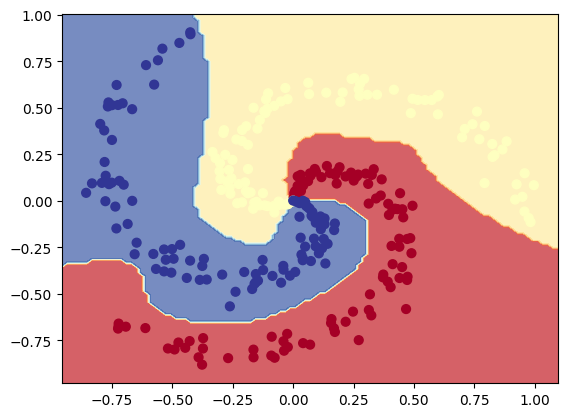

In [25]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_1, X, y)